In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm


'''
Notes: Some of these graphs are very large and so I had difficulty importing them
into my final deliverable. Additionally, I wrote most of this in a Jupyter Notebook,
so I didn't have to explicitly call plt.show() to display my graphs. It also means
that sometimes you see output at the end of a cell, which can be disregaded except
as a sanity/type check

'''

#Begin by parsing data

rawData = ["EPADataSets\\daily_06_037_1103_2016.csv", "EPADataSets\\daily_06_037_1103_2017.csv", 
           "EPADataSets\\daily_06_037_1103_2018.csv", "EPADataSets\\daily_06_037_1103_2019.csv",
           "EPADataSets\\daily_06_037_1103_2020.csv"]
        
#extract relevant variables
keepList = ["Ozone", "Nitrogen dioxide (NO2)", "Nitric oxide (NO)", "Carbon monoxide", "Sulfur dioxide",
           "Average Ambient Temperature"]    

allYears = []
for i in rawData:
    # Read the columns we want
    df = pd.read_csv(i, usecols=["Parameter Name", "Date (Local)", "Arithmetic Mean"])

    # Change date to datetime object
    #df["Date (Local)"] = pd.to_datetime(df["Date (Local)"])

    #Only keep the rows that contain data of relevant elements
    df = df[df["Parameter Name"].isin(keepList)]    
    
    #Rename wind directions
    #df.loc[df["Parameter Name"] == "Wind Direction - Scalar", "Parameter Name"] = "Wind Direction - Resultant"
    
    allYears.append(df)

print(allYears[0].head())

       Parameter Name Date (Local)  Arithmetic Mean
12  Nitric oxide (NO)   2016-01-01         5.160870
41    Carbon monoxide   2016-01-01         0.491304
42    Carbon monoxide   2016-01-01         0.422222
51     Sulfur dioxide   2016-01-01         0.091667
52     Sulfur dioxide   2016-01-01         0.075000


In [2]:
from statistics import mean 

#reformat the data the way we want it
cleandf = pd.DataFrame(columns=["Parameter", "Date", "Average"])

#average out repeats per day per parameter name
for year in allYears:
    year = year.groupby("Date (Local)")
    
    for key, grp in year:
        temp = {}
        #get the counts for each parameter per day
        for i, row in grp.iterrows():
            if(row[0] in temp):
                 temp[row[0]].append(row[2])
            else:
                 temp[row[0]] = [row[2]]
                
        #average out the counts for each perameter
        for parameter in temp:
            temp[parameter] = mean(temp[parameter])
        
        temp2 = {"Date": [], "Parameter":[], "Average":[]} 
        for parameter in temp:
            temp2["Date"].append(key)
            temp2["Parameter"].append(parameter)
            temp2["Average"].append(temp[parameter])
            
        tempdf = pd.DataFrame(temp2)
        cleandf = cleandf.append(tempdf)

In [3]:
cleandf = cleandf.pivot(index="Date", columns="Parameter", values="Average")
cleandf = cleandf.dropna()

In [4]:
#Let's explore the data a bit
print(len(cleandf), "\n")
print(cleandf.shape, "\n")
print(cleandf.info, "\n")
print(cleandf.isnull().sum(), "\n")

1640 

(1640, 6) 

<bound method DataFrame.info of Parameter   Average Ambient Temperature  Carbon monoxide  Nitric oxide (NO)  \
Date                                                                          
2016-01-01                        11.82         0.441777           4.970019   
2016-01-02                        14.00         0.546181          16.287682   
2016-01-03                        13.50         0.787658          29.230435   
2016-01-04                        16.20         0.444372           8.648642   
2016-01-05                        14.60         0.362291           7.527083   
...                                 ...              ...                ...   
2020-09-26                        22.60         0.347917           2.002084   
2020-09-27                        22.80         0.297916           0.964765   
2020-09-28                        24.20         0.425000           4.706250   
2020-09-29                        26.30         0.522917           8.384511   
2

In [14]:
target = pd.DataFrame(cleandf.loc[:,"Ozone"], columns=["Ozone"])
variables = cleandf.drop("Ozone", axis=1)

Text(0.5, 0, 'ppm')

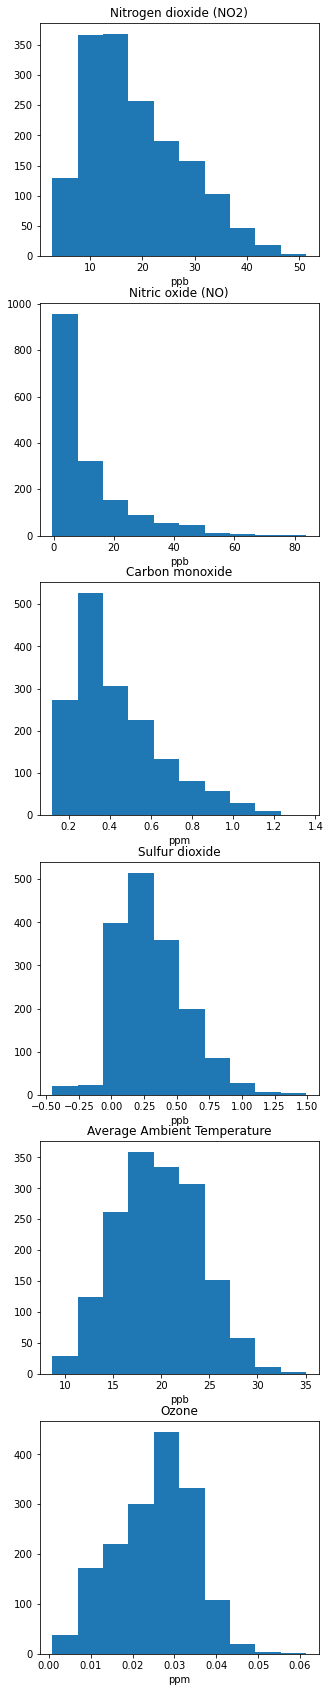

In [6]:
fig1, ax1 = plt.subplots(6, 1, figsize = (5, 30))

i = 0
for parameter in keepList:
    if parameter != "Ozone":
        ax1[i].hist(variables[parameter])
        ax1[i].set_title(parameter)
        if(parameter == "Carbon monoxide"):
            ax1[i].set_xlabel("ppm")
        else:
            ax1[i].set_xlabel("ppb")

        i += 1
        
ax1[i].hist(target["Ozone"])
ax1[i].set_title("Ozone")
ax1[i].set_xlabel("ppm")

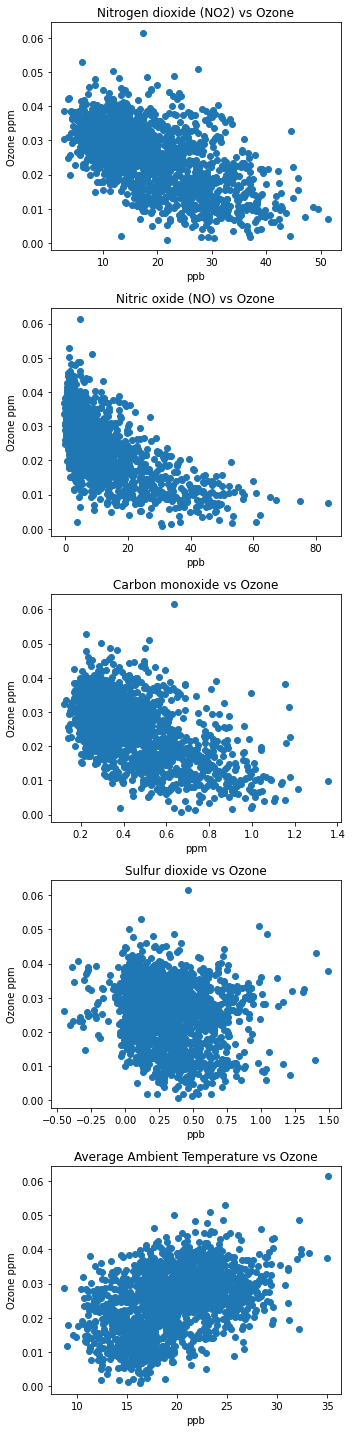

In [8]:
fig2, ax2 = plt.subplots(5, 1, figsize = (5, 20))

i = 0
for parameter in keepList:
    if parameter != "Ozone":
        ax2[i].scatter(variables[parameter], target["Ozone"])
        ax2[i].set_title(parameter + " vs Ozone")
        if(parameter == "Carbon monoxide"):
            ax2[i].set_xlabel("ppm")
        else:
            ax2[i].set_xlabel("ppb")
            
        ax2[i].set_ylabel("Ozone ppm")

        i += 1
                
        
fig2.tight_layout()

In [15]:
#now, getting into the actual machine learning part

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

x_train, x_test, y_train, y_test = train_test_split(variables, target, test_size=0.3, random_state=2020)

#Something to note is that the axes from the plots earlier 
#vary a lot (ppb vs ppm)
#To account for this let's scale
x_train = preprocessing.scale(x_train)
x_test = preprocessing.scale(x_test)
y_train = preprocessing.scale(y_train)
y_test = preprocessing.scale(y_test)

lin_model = LinearRegression()
lin_model.fit(x_train,y_train)

test_pred = lin_model.predict(x_test)
    
print("Training data score:", lin_model.score(x_train,y_train))
print("Testing data score:", lin_model.score(x_test,y_test))

Training data score: 0.5804274368655039
Testing data score: 0.5731489871678459


In [16]:
#trying to improve the model with cross validation
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score



alpha_space = np.logspace(-4, 0, 50)

model_scores = []

lasso_model = Lasso(normalize=True)
for alpha in alpha_space:

    # Specify the alpha value to use
    lasso_model.alpha = alpha
    
    # Perform 10-fold CV
    lasso_cv_scores = cross_val_score(lasso_model,x_train,y_train,cv=10)
    
    # Append the mean of lasso_cv_scores to model_scores = []
    model_scores.append(np.mean(lasso_cv_scores))

    
print("Training data score using lasso:", np.max(model_scores))

bestAlphaIndex = np.argmax(model_scores)
lasso_model.alpha = alpha_space[bestAlphaIndex]
lasso_model.fit(x_train, y_train)
print("Testing data score using lasso: ", lasso_model.score(x_test, y_test))

Training data score using lasso: 0.5711055260831954
Testing data score using lasso:  0.5744636661133027


In [17]:
model_scores = []

ridge_model = Ridge(normalize=True)
for alpha in alpha_space:

    # Specify the alpha value to use
    ridge_model.alpha = alpha
    
    # Perform 10-fold CV
    ridge_cv_scores = cross_val_score(ridge_model,x_train,y_train,cv=10)
    
    # Append the mean of lasso_cv_scores to model_scores = []
    model_scores.append(np.mean(ridge_cv_scores))

    
print("Training data score using ridge:", np.max(model_scores))

bestAlphaIndex = np.argmax(model_scores)
ridge_model.alpha = alpha_space[bestAlphaIndex]
ridge_model.fit(x_train, y_train)
print("Testing data score using ridge: ", ridge_model.score(x_test, y_test))

Training data score using ridge: 0.5714204360656469
Testing data score using ridge:  0.5737411667807468


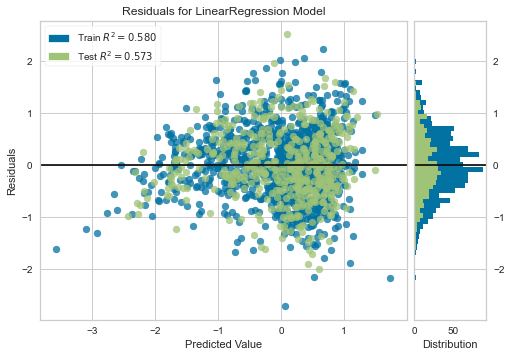

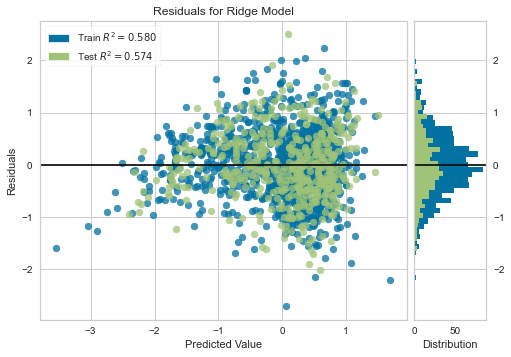

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [19]:
from yellowbrick.regressor import ResidualsPlot
import seaborn as sns

#These residuals with their trumpet shape indicate
#that there are other relevant predictors. 
#It's probably hydrocarbons, which I couldn't find
#High quality, consistent datasets are difficult to 
#find, so I'm sticking with this with the acknowledgement
#that I'm missing that other predictor(s)
visualizer = ResidualsPlot(lin_model)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.poof()


visualizer = ResidualsPlot(ridge_model)
visualizer.fit(x_train, y_train)  
visualizer.score(x_test, y_test)  
visualizer.poof()

# visualizer = ResidualsPlot(lasso_model)
# visualizer.fit(x_train, y_train)  
# visualizer.score(x_test, y_test)  
# visualizer.poof()

In [95]:
#trying to improve the model using boosting

import xgboost as xgb

data_dmatrix = xgb.DMatrix(data=variables,label=target)
data_dmatrix
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(x_train,y_train)


xg_test_pred = xg_reg.predict(x_test)
xg_train_pred = xg_reg.predict(x_train)


rmse = np.sqrt(mean_squared_error(y_train, xg_train_pred))
print("RMSE: %f" % (rmse))

rmse = np.sqrt(mean_squared_error(y_test, xg_test_pred))
print("RMSE: %f" % (rmse))

print("Training data score:", xg_reg.score(x_train,y_train))
print("Testing data score:", xg_reg.score(x_test,y_test))
#It's improved...a little bit

RMSE: 0.605974
RMSE: 0.639625
Training data score: 0.6327957699745272
Testing data score: 0.5908792859536407


In [85]:
#try to improve using cross validation
#first set up hyperparameters 
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=2020)

#get the best best RSME
print(cv_results.iloc[len(cv_results)-1])

train-rmse-mean    0.013637
train-rmse-std     0.000043
test-rmse-mean     0.013652
test-rmse-std      0.000520
Name: 49, dtype: float64


In [86]:
#with thanks to https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
gridsearch_params = [
    (max_depth)
    for max_depth in range(3,10)
]

min_rmse = float("Inf")
best_params = None

for max_depth in gridsearch_params:
    # Update our parameters
    params['max_depth'] = max_depth
    # Run CV
    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=2020)
    # Update best MAE
    mean_rmse = cv_results['train-rmse-mean'].min()
    boost_rounds = cv_results['train-rmse-mean'].argmin()
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth)
        
params["max_depth"] = best_params
print(params["max_depth"])


3


In [87]:
min_rsme = float("Inf")
best_params = None
for learning_rate in [.4, .3, .2, .1, .05, .01, .005]:
    # We update our parameters
    params['learning_rate'] = learning_rate
    # Run and time CV
    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=2020)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = learning_rate

params["learning_rate"] = best_params
print(params["learning_rate"])

0.3


In [88]:
gridsearch_params = [
    (colsample)
    for colsample in [i/10. for i in range(1, 7)]
]

min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for colsample in reversed(gridsearch_params):
    # We update our parameters
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=2020)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (colsample)
        
params["colsample_bytree"] = best_params
print(params["colsample_bytree"])

0.5


In [89]:
gridsearch_params = [
    (alpha)
    for alpha in range(6, 13)
]

min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for alpha in gridsearch_params:
    # We update our parameters
    params['alpha'] = alpha
    # Run CV
    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=2020)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (alpha)
        
params["alpha"] = best_params
print(params["alpha"])

6


In [90]:
print(params)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=2020)

#Printing out final RMSE
print(cv_results.iloc[len(cv_results)-1])


{'objective': 'reg:squarederror', 'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 3, 'alpha': 6}
train-rmse-mean    0.009815
train-rmse-std     0.000059
test-rmse-mean     0.009896
test-rmse-std      0.000322
Name: 49, dtype: float64


In [91]:
#create another model with the updated parameters
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.3,
                max_depth = 3, alpha = 6, n_estimators = 100)
xg_reg.fit(x_train,y_train)

xg_test_pred = xg_reg.predict(x_test)
xg_train_pred = xg_reg.predict(x_train)

print("Training data score using optimized parameters: ", xg_reg.score(x_train, y_train))
print("Testing data score using optimized parameters: ", xg_reg.score(x_test, y_test))

Training data score using optimized parameters:  0.7418738374233047
Testing data score using optimized parameters:  0.6232516218994382


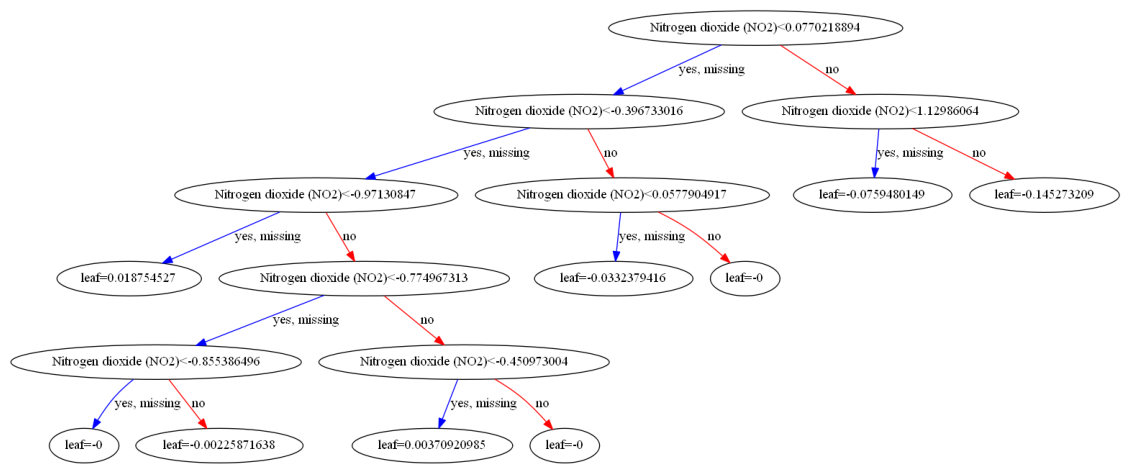

In [108]:
#Let's see the xg_reg tree
xg_reg.get_booster().feature_names = ['Average Ambient Temperature', 
                                      'Carbon monoxide', 'Nitric oxide (NO)',
                                      'Nitrogen dioxide (NO2)', 
                                      'Sulfur dioxide']
xgb.plot_tree(xg_reg,num_trees=1)
plt.savefig("XGBoostTree", dpi=200)
plt.rcParams['figure.figsize'] = [80, 80]
plt.show()


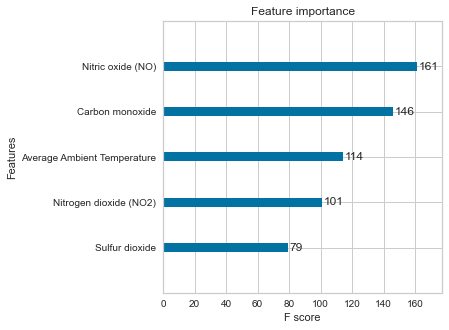

In [100]:
xgb.plot_importance(xg_reg)
#plt.rcParams['figure.figsize'] = [5, 5]
plt.show()